In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
!pip install matplotlib


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [50]:
BATCH_SIZE = 16
IMAGE_SIZE1 = 270
IMAGE_SIZE2 =195
CHANNELS=3
EPOCHS=30

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE1,IMAGE_SIZE2),
    batch_size=BATCH_SIZE
)

Found 5216 files belonging to 2 classes.


In [6]:
class_names = dataset.class_names
class_names


['NORMAL', 'PNEUMONIA']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[35.       35.       35.      ]
  [39.916637 39.916637 39.916637]
  [35.134476 35.134476 35.134476]
  ...
  [28.071272 28.071272 28.071272]
  [29.012989 29.012989 29.012989]
  [26.886759 26.886759 26.886759]]

 [[36.844242 36.844242 36.844242]
  [37.26205  37.26205  37.26205 ]
  [38.85029  38.85029  38.85029 ]
  ...
  [31.       31.       31.      ]
  [30.18457  30.18457  30.18457 ]
  [29.830585 29.830585 29.830585]]

 [[38.154415 38.154415 38.154415]
  [39.560257 39.560257 39.560257]
  [41.37678  41.37678  41.37678 ]
  ...
  [29.360159 29.360159 29.360159]
  [29.97735  29.97735  29.97735 ]
  [28.128016 28.128016 28.128016]]

 ...

 [[17.707987 17.707987 17.707987]
  [26.       26.       26.      ]
  [24.99169  24.99169  24.99169 ]
  ...
  [26.       26.       26.      ]
  [26.       26.       26.      ]
  [17.13381  17.13381  17.13381 ]]

 [[27.       27.       27.      ]
  [26.       26.       26.      ]
  [25.       25.       25.      ]
  ...
  [26.       26.       26.      ]
  [2

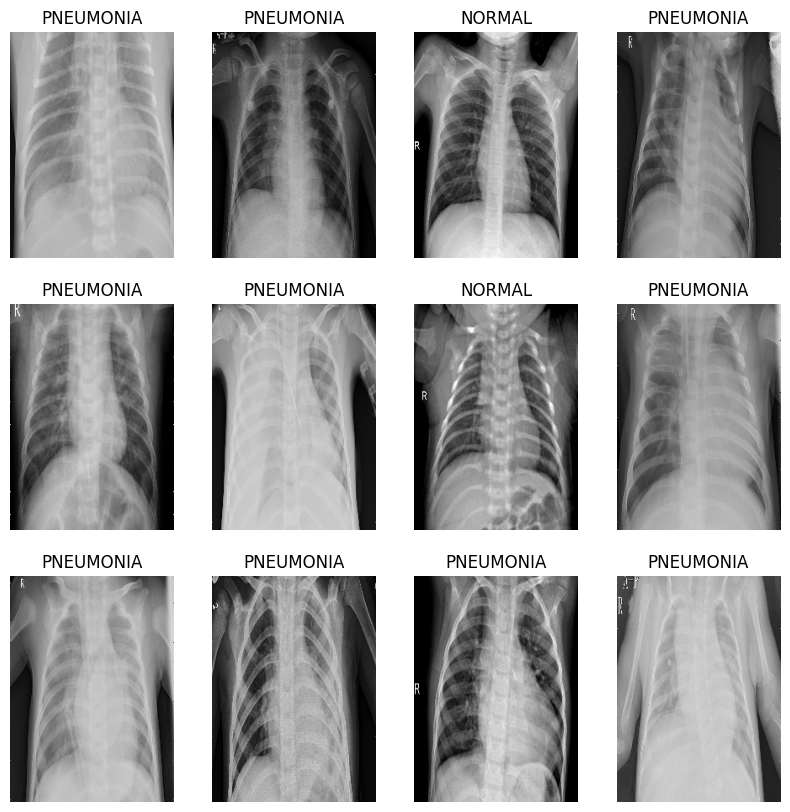

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size


260.8

In [16]:
train_ds = dataset.take(260)
len(train_ds)

260

In [17]:
test_ds = dataset.skip(260)
len(test_ds)


66

In [18]:
val_size=0.1
len(dataset)*val_size


32.6

In [19]:
val_ds = test_ds.take(32)
len(val_ds)

32

In [20]:
test_ds = test_ds.skip(32)
len(test_ds)


34

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [23]:
len(train_ds)


260

In [24]:
len(val_ds)


32

In [25]:
len(test_ds)


34

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
from tensorflow.keras import layers, Sequential

In [28]:
resize_and_rescale = Sequential([layers.Resizing(IMAGE_SIZE1, IMAGE_SIZE2),layers.Rescaling(1./255),])

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Resizing, Rescaling


In [30]:
resize_and_rescale = Sequential([Resizing(IMAGE_SIZE1, IMAGE_SIZE2),Rescaling(1./255),])

In [31]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [32]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE1, IMAGE_SIZE2, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [36]:
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (16, 270, 195, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (16, 268, 193, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (16, 134, 96, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (16, 132, 94, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (16, 66, 47, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (16, 64, 45, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (16, 32, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (16, 30, 20, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (16, 15, 10, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (16, 13, 8, 64)             │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (16, 6, 4, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (16, 4, 2, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (16, 2, 1, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (16, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (16, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (16, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 175,555 (685.76 KB)

 Trainable params: 175,555 (685.76 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 87s 288ms/step - accuracy: 0.7422 - loss: 0.6097 - val_accuracy: 0.7559 - val_loss: 0.5109
Epoch 2/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 68s 263ms/step - accuracy: 0.7627 - loss: 0.5114 - val_accuracy: 0.8438 - val_loss: 0.3515
Epoch 3/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 263ms/step - accuracy: 0.8540 - loss: 0.3306 - val_accuracy: 0.8887 - val_loss: 0.2973
Epoch 4/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 263ms/step - accuracy: 0.8786 - loss: 0.2910 - val_accuracy: 0.8965 - val_loss: 0.2477
Epoch 5/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 265ms/step - accuracy: 0.8969 - loss: 0.2527 - val_accuracy: 0.8867 - val_loss: 0.2756
Epoch 6/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 264ms/step - accuracy: 0.8977 - loss: 0.2427 - val_accuracy: 0.8965 - val_loss: 0.2603
Epoch 7/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 264ms/step - accuracy: 0.9167 - loss: 0.2272 - val_accuracy: 0.9102 - val_loss: 0.2417
Epoch 8/30
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 265ms/step - accuracy: 0.9239 - loss: 0

In [39]:
scores = model.evaluate(test_ds)


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.9527 - loss: 0.1263


In [42]:
history


In [43]:
history.params


{'verbose': 1, 'epochs': 30, 'steps': 260}

In [44]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [45]:
type(history.history['loss'])


list

In [48]:
len(history.history['loss'])


30

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


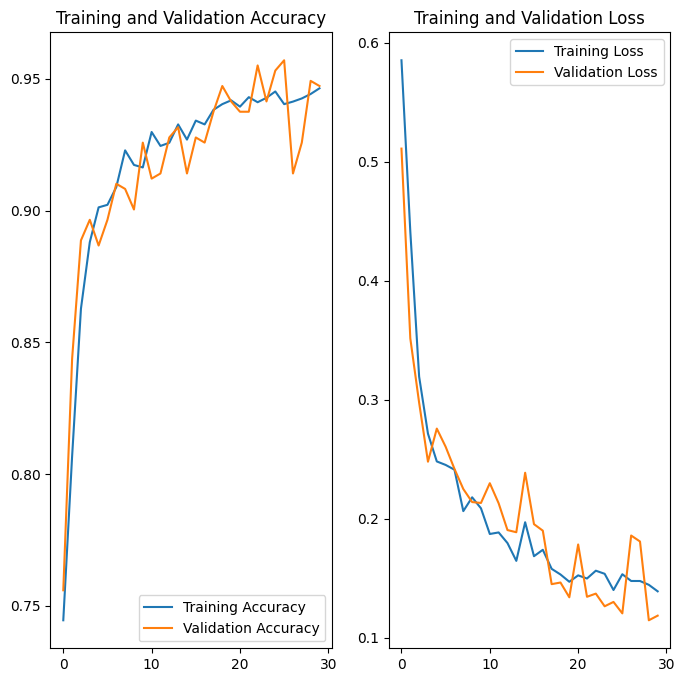

In [52]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
predicted label: PNEUMONIA


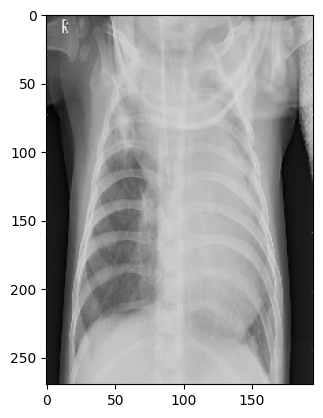

In [66]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [67]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


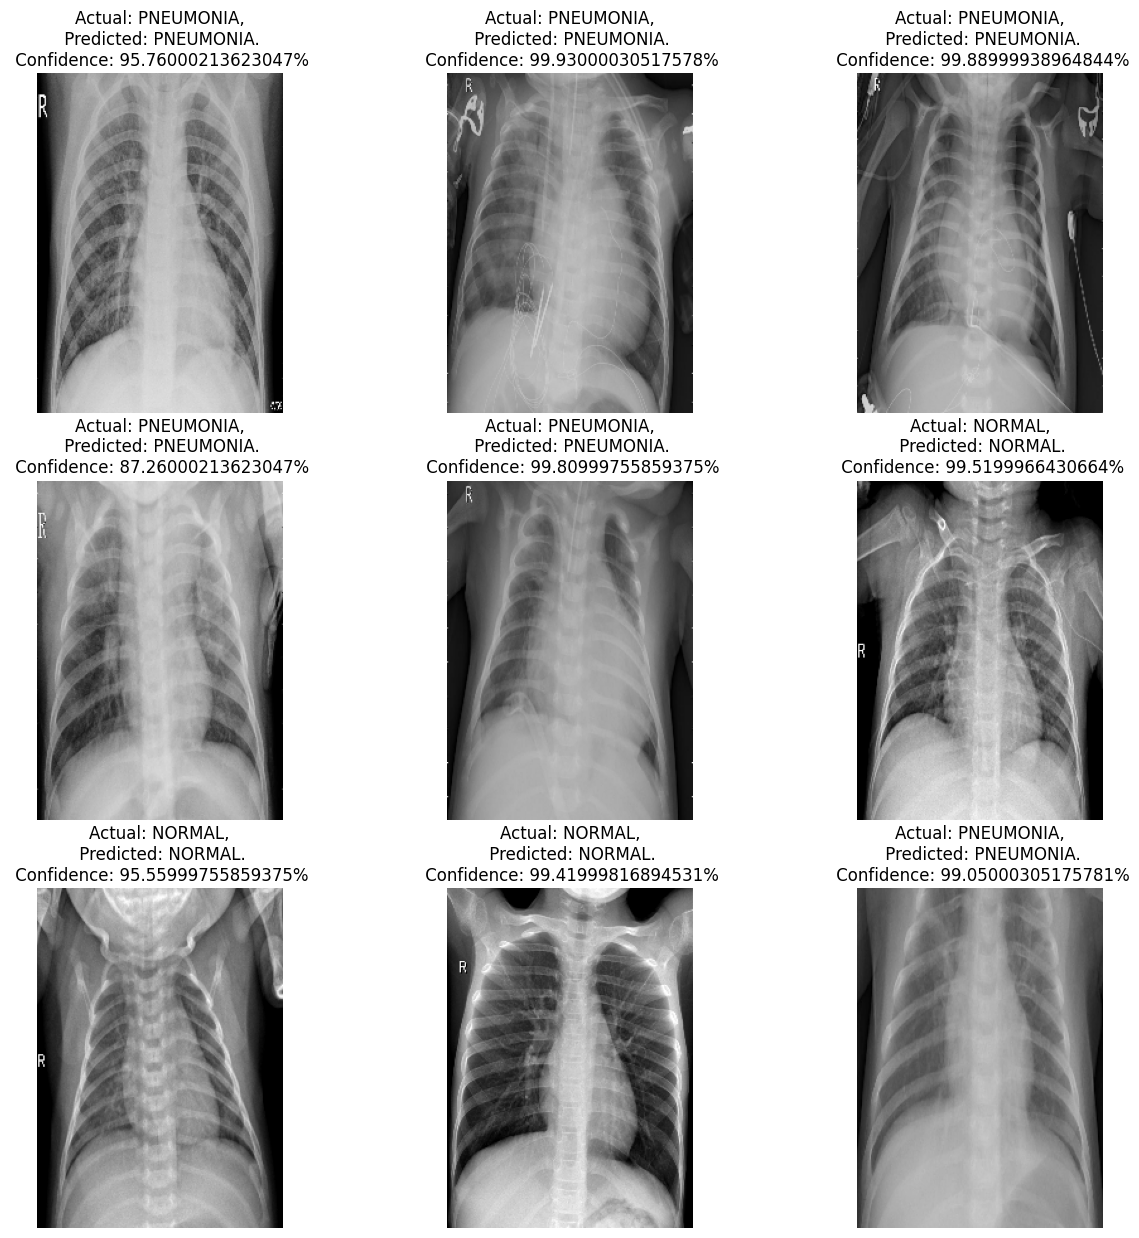

In [68]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [81]:
import os

# 1) Ensure the base “models” folder exists
os.makedirs("models", exist_ok=True)

# 2) Compute next version
existing = [int(d) for d in os.listdir("models") if d.isdigit()]
model_version = max(existing + [0]) + 1
version_path = f"saved_models/{model_version}"

model.save(f"{version_path}.keras")

# 3a) Use the Keras 3 export API to produce a SavedModel folder
model.export(version_path)

# Resulting structure:
# models/
# └── 1/
#     ├── assets/
#     ├── variables/
#     └── saved_model.pb


INFO:tensorflow:Assets written to: saved_models/2\assets


INFO:tensorflow:Assets written to: saved_models/2\assets


Saved artifact at 'saved_models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 270, 195, 3), dtype=tf.float32, name='keras_tensor_40')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2219354442208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354443264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354448544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354703824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354702416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354702592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354707696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354706112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354708576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354706992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2219354710864: TensorSpec(shape=(